# **Hacker News Sentiment Toward TikTok Bans and Their Policy Implications**

The policy [debate](https://www.atlanticcouncil.org/blogs/new-atlanticist/your-expert-guide-to-the-debate-over-banning-tiktok/) surrounding the U.S. government’s attempts to ban or force the sale of TikTok has drawn intense public attention. Supporters argue that restricting TikTok’s Chinese ownership is necessary to protect national security and prevent potential foreign access to Americans’ data. Critics respond that these proposals threaten digital rights, freedom of expression, and the livelihoods of creators who rely on TikTok for economic opportunities.

While polling is often used to characterize national opinion, a significant portion of the policy discourse takes place online—especially on platforms where technologically savvy users engage in political and technical analysis. [Hacker News](https://news.ycombinator.com/) (HN), a social news forum popular among software developers, cybersecurity practitioners, and tech entrepreneurs, stands out as a community whose members are deeply informed about core issues in this debate: data privacy, software architecture, platform governance, and state power.

Understanding sentiment and argumentation on Hacker News is policy-relevant because these users often contribute to, shape, or consult on technology regulation. Their reactions reveal how well lawmakers’ arguments resonate with people who understand the technical tradeoffs.

This project analyzes Hacker News discussions related to the TikTok ban, using sentiment analysis and TF-IDF to examine:

How positive or negative the community is toward banning TikTok, and

What kinds of arguments dominate the discourse (e.g., national security, privacy rights, antitrust concerns, U.S.–China geopolitical rivalry).

Findings offer insight into whether technically informed publics view the TikTok ban as a necessary security measure or as a policy overreach with unintended consequences.

This project analyzes Hacker News comment responses to stories related to TikTok bans. Hacker News represents a technologically literate and politically engaged community whose opinions are not representative of the broader public, but are important in shaping discourse around technology governance, data security, and free-expression regulation.

Using the public Hacker News API, I collected comments from the top 20 highest-engagement threads returned for the search query “tiktok ban.” I applied VADER sentiment analysis to each comment to compute compound sentiment scores ranging from `[–1,1]`. The overall mean compound sentiment across the dataset was `–0.01`, indicating a neutral to slightly negative orientation toward TikTok bans among this community.

I then tested how sentiment relates to discussion engagement by plotting each comment’s VADER score against its number of replies (“sub-comments”). The results show that more positive comments tend to receive more responses, suggesting that Hacker News users are more likely to participate in conversations framed positively, despite a generally skeptical stance toward bans overall.

To compare perspectives in different geopolitical contexts, I performed two additional queries focused on U.S. TikTok ban discourse and India’s TikTok ban discourse. Sentiment toward U.S. policy actions was slightly positive (`0.06`), while reaction to India’s ban was neutral to slightly positive (`0.01`), indicating that Hacker News users may view U.S. regulatory intervention as more legitimate or technically justified than similar actions abroad.

Finally, I used TF-IDF to identify distinctive language patterns within comments in the main dataset (query: "tiktok ban"), and visualized the TF-IDF scores for the term “security.” This showed that “security” is regularly invoked in TikTok ban discussions, reinforcing that for this technically informed audience, national security and data governance concerns are central frames in evaluating the policy.

Together, these findings show that Hacker News users react to TikTok bans through a lens grounded in security risk, technical legitimacy, and political context, and that positive framings generate more engagement, implying that persuasive narratives may carry greater influence than purely critical ones in online tech-policy debate.

# **Methods**




## **Data Collection**

Using Python and the public Hacker News API, I collected all available comments from the top 20 search results returned for "tiktok ban". Each record includes comment text, comment ID, and the number of replies (“sub-comments”). Two additional searches were run:

1. “US tiktok ban” and
2. “India tiktok ban”

to support a cross-geopolitical comparison.

To clean the data, I removed flagged and dead comments as well as non-alphanumeric characters (which are often included in the context of markdown or HTML). The final dataset included ~850 comments for the main TikTok ban analysis.

To perform the API queries I wrote a simple function using the `requests` library and by referencing the below API documentation. We use the function `hn_search()` to return search results. For each result we can extract the list of IDs for its comments. Then we use `hn_item()` to return information on each comment by passing its ID. This data includes the comment text, as well as the IDs for each of its replies.

API documentation referenced:
- https://hn.algolia.com/api
- https://github.com/HackerNews/API

### Pulling comments from Hacker News

In [42]:
import requests                    # used to perform HTTP request to API
from urllib.parse import urlencode # used to encode parameters of query
import re                          # used for data cleaning

In [46]:
def hn_search(params: dict):
  """Queries the Algolia Hacker News search API.
     `params` can be used to specifiy search
     term and additional parameters like tags"""
  url = f"https://hn.algolia.com/api/v1/search?{urlencode(params)}"
  response = requests.get(url)
  return response.json()["hits"]

def hn_item(item: str):
  """Queries the Hacker News API for item
  (story, comment, etc.) information"""
  #print(item)
  url = f"https://hacker-news.firebaseio.com/v0/item/{item}.json?print=pretty"
  response = requests.get(url)
  return response.json()

In [56]:
# paramters to search for stories by query "tiktok ban"
p = {"query": "tiktok ban", "tags": "story"}
story_titles = [hit["title"] for hit in hn_search(p)]

for i, st in enumerate(story_titles):
  print(f"{i+1}. \"{st}\"")

1. "India bans TikTok, WeChat, and dozens of other Chinese apps"
2. "Supreme Court upholds TikTok ban, but Trump might offer lifeline"
3. "TikTok Ban Bill Is Patriot Act 2.0 Trojan Horse [video]"
4. "Trudeau government bans TikTok from operating in Canada"
5. "Nepal bans TikTok and says it disrupts social harmony"
6. "Amazon says email banning TikTok from employee phones was ‘sent in error’"
7. "Senate Bill to Ban TikTok"
8. "South Dakota first to ban TikTok on state-owned devices"
9. "Trump says he will ban TikTok through executive action"
10. "U.S. Navy bans TikTok from government-issued mobile devices"
11. "TikTok banned on government devices under spending bill passed by Congress"
12. "Bipartisan Legislation to Ban TikTok"
13. "New York City bans TikTok for government employees"
14. "EFF statement on U.S. Supreme Court's decision to uphold TikTok ban"
15. "Overrun by influencers, historic sites are banning TikTok creators in Nepal"
16. "The TikTok ban is a betrayal of the open inte

In [45]:
# the comments of a Hacker News story are called 'children'
# `story_children` is a list of the comment ids
story_children = [child_id for story in hn_search(p) if "children" in story.keys() for child_id in story["children"]]

print(f"Got {len(story_children)} comment IDs, e.g.: {story_children[0]}")

Got 918 comment IDs, e.g.: 23679481


In [52]:
# fetch comment data for each of the above comment ids
comments = []
for story_child in story_children:
  try:
    comments.append(hn_item(story_child))
  except:
    print(f"Error requesting item {story_child}")

print(f"Got {len(comments)} comments, e.g.: {comments[0]}...")

Got 918 comments, e.g.: {'by': 'president', 'id': 23679481, 'kids': [23680338, 23680396, 23680589, 23680507, 23682466, 23680798, 23680606], 'parent': 23679286, 'text': 'Glad to see India understanding the threat to national security posed by these apps. I would like to see the US do the same.', 'time': 1593450380, 'type': 'comment'}...


In [60]:
# extract the comment text from each comment data
# we clean this data by removing comments with no text
# as well as comments marked as 'flagged' or 'dead'
# as well as removing non-alphanumeric characters from the text
comment_text = [
    c["text"] for c in comments
    if "text" in c.keys()       and # data cleaning
       c["text"] != "[flagged]" and # data cleaning
       c["text"] != "[dead]"        # data cleaning
]
comment_text = [
    re.sub(r'[^a-zA-Z0-9\s]', '', text) # data cleaning
    for text in comment_text
]

print(f"Extracted text from {len(comment_text)} comments, e.g.: \"{comment_text[0][0:39]}...\" (discarded {len(comments) - len(comment_text)} comments in cleaning)")

Extracted text from 837 comments, e.g.: "Glad to see India understanding the thr..." (discarded 81 comments in cleaning)


## Sentiment Analysis
Sentiment was measured using VADER, which computes a compound sentiment score from –1 (strongly negative) to +1 (strongly positive). Following common thresholds:

Positive: > +0.05

Neutral: between –0.05 and +0.05

Negative: < –0.05

Using the code from class, I first installed necessary libraries (`nltk`). I then performed VADER analysis on each comment to give it a score. In order to visualize the data, I created a scatter plot to plot the comments based on their VADER score and the data's mean (as a horizontal line) for reference.

### Perform VADER analysis on comments

In [54]:
# install/import nltk
!pip -q install --upgrade nltk
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [12]:
def compound_score(text):
  """Return compound score in range [-1,1]"""
  return sia.polarity_scores(text or "")["compound"]

# Common VADER thresholds
POS, NEG = 0.05, -0.05

In [59]:
# calculate VADER score for each comment
comment_scores = [compound_score(text) for text in comment_text]

print(f"Calculated {len(comment_scores)} comment score, e.g.: {comment_scores[0]}")

Calculated 837 comment score, e.g.: 0.5423


In [32]:
# plot VADER score for each comment
import plotly.graph_objects as go
import numpy as np

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(0,len(comment_scores))),
    y=comment_scores,
    mode='markers',
    marker=dict(size=4, color="skyblue"),
    name="Hacker News comments",
    hovertext=comment_text,
    hovertemplate="<b>Comment:</b> %{hovertext}<br><br><b>Compound:</b> %{y:.2f}<extra></extra>"
  ))

# add horizontal line for mean comment score
fig.add_trace(go.Scatter(
    x=[0, len(comment_scores)],
    y=[np.mean(comment_scores), np.mean(comment_scores)],
    mode="lines",
    line=dict(color="red", width=3, dash="dash"),
    name=f"Mean Compund Sentiment Score ({np.mean(comment_scores):.2f})"
))

fig.update_layout(
    title="Sentiment Scores for Hacker News comments with Mean Compound Score",
    xaxis_title="Comment Index",
    yaxis_title="Compound Sentiment Score",
    title_x=0.5
)

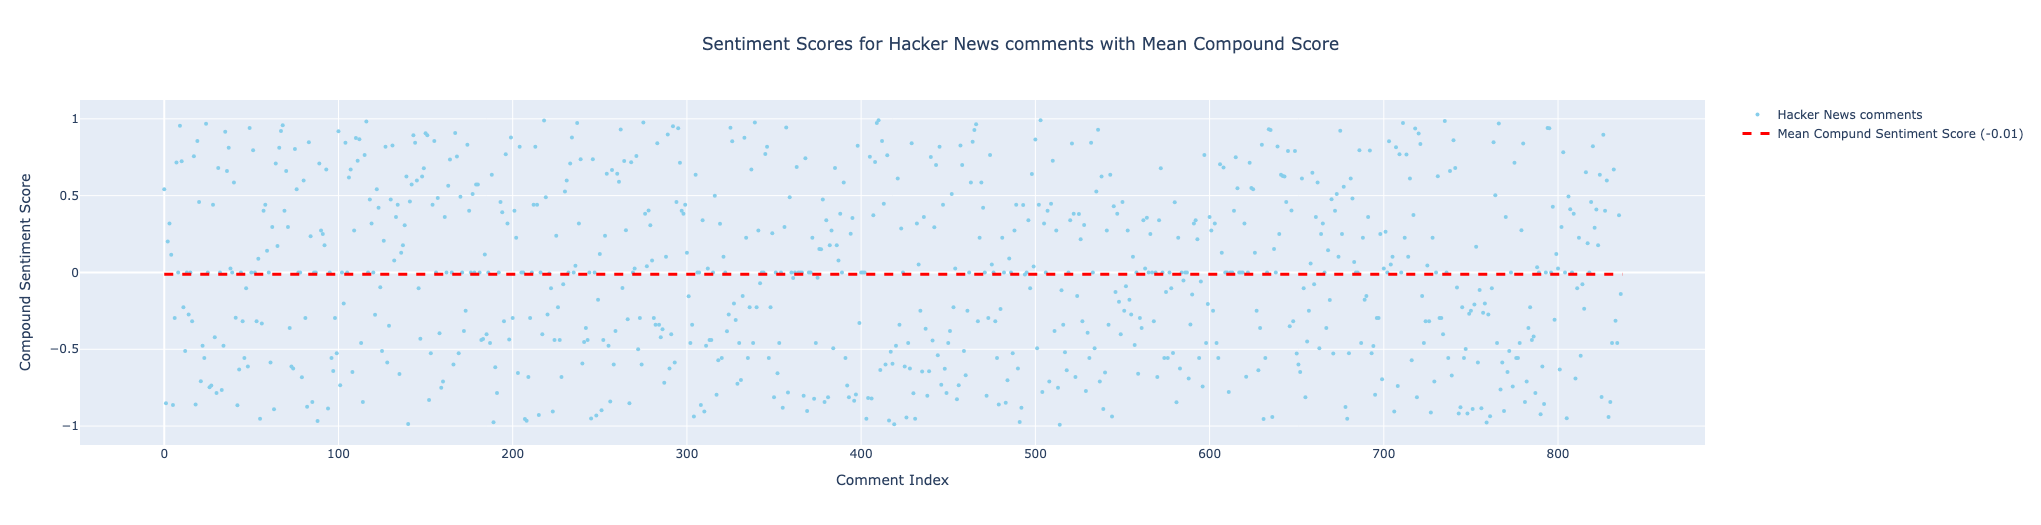

As we can see from the scatter plot, the comment corpus is well distributed: comments are fairly uniformly distributed in the VADER range of `[-1,1]`. The above figure uses the Plotly plotting library which allows users to hover over points to see the points score and comment text. The scaffold for the Plotly plots was generated by ChatGPT with the prompt "python code to create a scatter plot of data using Plotly".

## Plotting Sentiment vs Comment response count

Next I wanted to study the broader discussion sparked by each comment, rather than the users responses to the story itself (as done above). In order to do so, for each comment on the above stories I queried all of its replies (sub-comments). To see how the sentiment of a comment impacted the likelihood of other users engaging (e.g. replying) with it, I plotted the VADER score of each comment vs its number of sub-comments, and fit a linear best fit line to the data.

This best fit line had a slope of `0.7 > 0` which shows that more positive comments are more likely to receive more replies than more negative comments. This provides a very interesting characterization of the Hacker News community.

The `numpy` code to find the line of best fit was provided by ChatGPT with the prompt: "python code for best fit line for plot".

In [62]:
# extract the number of subcomment for each comment
comment_kids = [
    len(c["kids"]) if "kids" in c.keys() else 0
    for c in comments
      if "text" in c.keys()      and # data cleaning
        c["text"] != "[flagged]" and # data cleaning
        c["text"] != "[dead]"        # data cleaning
]
comment_text = [
    re.sub(r'[^a-zA-Z0-9\s]', '', text) # data cleaning
    for text in comment_text
]

print(f"Extracted {len(comment_kids)} subcomment counts, e.g.: {comment_kids[0]}")

Extracted 837 subcomment counts, e.g.: 7


In [34]:
# plot the VADER score of the comment vs the number of its subcomments
fig = go.Figure()

# calculate best fit line to access relationship
# between VADER score and engagement
z = np.polyfit(comment_scores, comment_kids, 1)
best_fit_line = np.poly1d(z)

# plot VADER and subcomment count
fig.add_trace(go.Scatter(
  x=comment_scores,
  y=comment_kids,
  mode="markers",
  marker=dict(size=4, color="skyblue"),
  name="Hacker News comments",
  hovertext=comment_text,
  hovertemplate="<b>Comment:</b> %{hovertext}<br><br><b>Subcomment count:</b> %{y:.2f}<extra></extra>"
))

# plot best fit line
fig.add_trace(go.Scatter(
    x=comment_scores,
    y=best_fit_line(comment_scores),
    mode="lines",
    line=dict(color="red", width=3, dash="dash"),
    name=f"Best fit line: y={z[0]:.2f}x + {z[1]:.2f}"
))

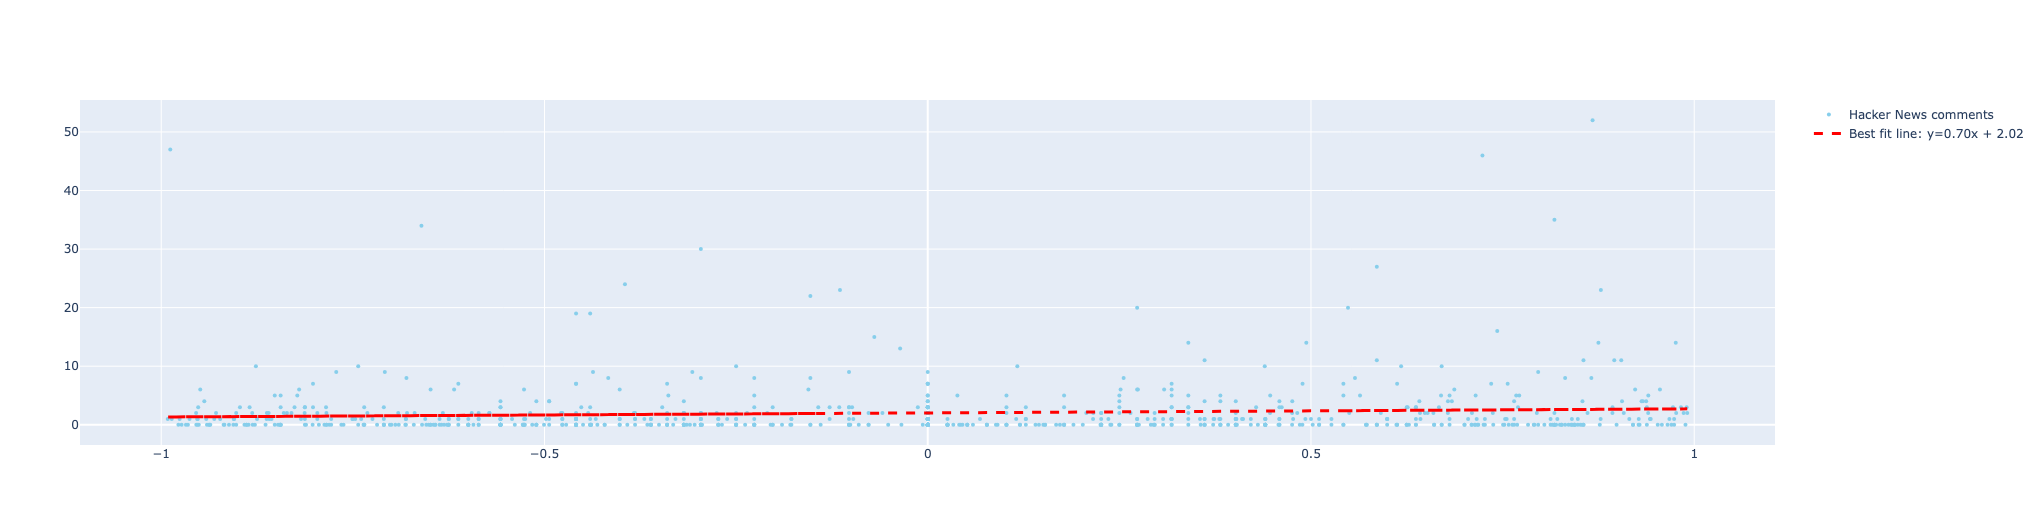

As noted above, the primary take-away from this analysis and visualization is that the more positive a comment is the more replies it is likely to recieve.

## Comparing Sentiment between U.S. & India TikTok bans

In order to run a cross-geopolitical comparison, I ran two additional queries:

1. "US tiktok ban"
2. "India tiktok ban"

For each query, I collected comment IDs from the top 20 story results and performed VADER analysis to get the scores for each comment. I then calculated the mean score for US ban comments and India ban comments and plotted this to compare the results.

In [17]:
# two new queries for US and India specific TikTok bans, repsectively
US_p = {"query": "US tiktok ban", "tags": "story"}
India_p = {"query": "India tiktok ban", "tags": "story"}

In [63]:
# get comment ids for stories from each query
US_story_children = [child_id for story in hn_search(US_p) if "children" in story.keys() for child_id in story["children"]]
print(f"Got {len(US_story_children)} comment IDs on US query, e.g.: {US_story_children[0]}")

India_story_children = [child_id for story in hn_search(India_p) if "children" in story.keys() for child_id in story["children"]]
print(f"Got {len(India_story_children)} comment IDs on India query, e.g.: {India_story_children[0]}")

Got 79 comment IDs on US query, e.g.: 40146287
Got 134 comment IDs on India query, e.g.: 23679481


In [64]:
# get comment data for above comments
US_comments = []
for story_child in US_story_children:
  try:
    US_comments.append(hn_item(story_child))
  except:
    print(f"Error requesting item {story_child}")

print(f"Got {len(US_comments)} comments on US query, e.g.: {US_comments[0]}...")

India_comments = []
for story_child in India_story_children:
  try:
    India_comments.append(hn_item(story_child))
  except:
    print(f"Error requesting item {story_child}")

print(f"Got {len(India_comments)} comments on India query, e.g.: {India_comments[0]}...")

Got 79 comments on US query, e.g.: {'by': 'skilled', 'id': 40146287, 'kids': [40149042, 40146343], 'parent': 40146203, 'text': 'This got submitted first and got a discussion going already,<p><a href="https:&#x2F;&#x2F;news.ycombinator.com&#x2F;item?id=40145963">https:&#x2F;&#x2F;news.ycombinator.com&#x2F;item?id=40145963</a>', 'time': 1713975812, 'type': 'comment'}...
Got 134 comments on India query, e.g.: {'by': 'president', 'id': 23679481, 'kids': [23680338, 23680396, 23680589, 23680507, 23682466, 23680798, 23680606], 'parent': 23679286, 'text': 'Glad to see India understanding the threat to national security posed by these apps. I would like to see the US do the same.', 'time': 1593450380, 'type': 'comment'}...


In [67]:
# extract comment text from above comment data
US_comment_text = [c["text"] for c in US_comments if "text" in c.keys()]
US_comment_text = [
    re.sub(r'[^a-zA-Z0-9\s]', '', text) # data cleaning
    for text in US_comment_text
]

print(f"Extracted text from {len(US_comment_text)} comments on US query, e.g.: \"{US_comment_text[0][0:39]}...\" (discarded {len(US_comments) - len(US_comment_text)} comments in cleaning)")

India_comment_text = [c["text"] for c in India_comments if "text" in c.keys()]
India_comment_text = [
    re.sub(r'[^a-zA-Z0-9\s]', '', text) # data cleaning
    for text in India_comment_text
]

print(f"Extracted text from {len(India_comment_text)} comments on India query, e.g.: \"{India_comment_text[0][0:39]}...\" (discarded {len(India_comments) - len(India_comment_text)} comments in cleaning)")

Extracted text from 74 comments on US query, e.g.: "This got submitted first and got a disc..." (discarded 5 comments in cleaning)
Extracted text from 128 comments on India query, e.g.: "Glad to see India understanding the thr..." (discarded 6 comments in cleaning)


In [69]:
# calculate VADER score for each comment
US_comment_scores = [compound_score(text) for text in US_comment_text]
India_comment_scores = [compound_score(text) for text in India_comment_text]

In [72]:
# calculate mean VADER score for US query comments and India query comments
US_mean_comment_score = np.mean(US_comment_scores)
India_mean_comment_score = np.mean(India_comment_scores)

print(f"Calculated US ({US_mean_comment_score:.2f}) & India ({India_mean_comment_score:.2f}) mean VADER score")

Calculated US (0.06) & India (0.01) mean VADER score


In [74]:
# plot mean VADER score to compare US vs India queries
fig = go.Figure()

fig.add_trace(go.Bar(
    x=["US TikTok Ban", "India TikTok Ban"],
    y=[US_mean_comment_score, India_mean_comment_score],
    marker_color=["skyblue", "lightcoral"]
))

fig.update_layout(
    title="Mean Compound Sentiment Score: US vs. India TikTok Ban (Hacker News)",
    xaxis_title="Topic",
    yaxis_title="Mean Compound Sentiment Score",
    title_x=0.5,
    bargap=0.5,
    yaxis_range=[0.0, 0.07]
)

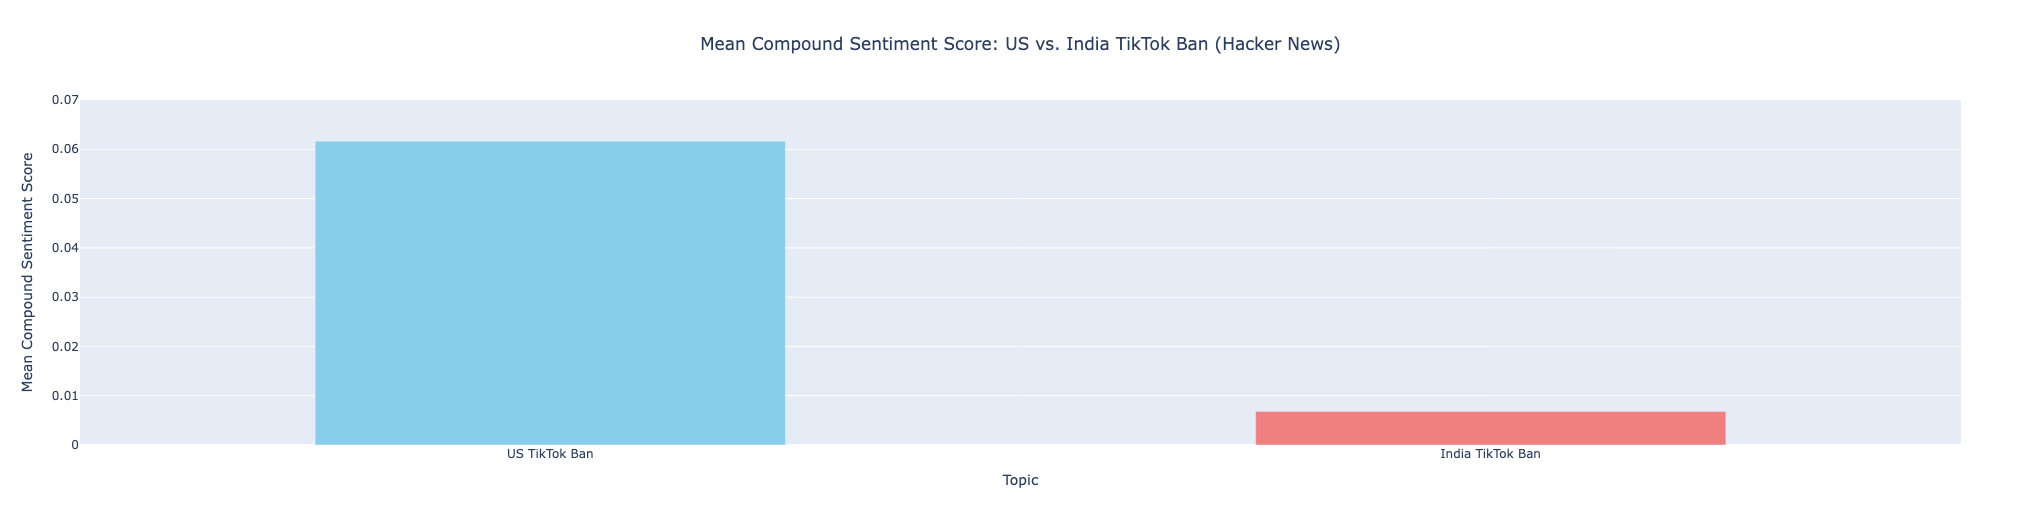

As can be seen in the above bar chart, the sentiment towards the US ban is more positive in comparison to the India TikTok ban among the Hacker News community. The mean score of the comments on the US ban stories is `0.06`, which is just above the common positive score threshold of `0.05`. The mean score of the comments on the India ban stories is `0.01`, which is in the neutral score range `[-0.05,0.05]` but it is still a positive number.

## TF-IDF

To explore substantive themes in the comments, I ran a TF-IDF vectorizer and extracted weights specifically associated with the term “security”, which emerged as a dominant keyword during pre-processing.

By modifying the code from class, I constructed a function `term_tfidf()` which returns the TF-IDF score for a list of comments and a given term. I then plotted the TF-IDF score for the term "security" for each of the comments. As can be seen in the plot, "security" was a significant theme across the corpus of comments.

In [73]:
# import sklearn and nltk utilities to perform TF-IDF
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist

In [25]:
def term_tfidf(comments, term):
  """returns TF-IDF score from each comment
  in `comments` for the term `term`"""
  tfidf = TfidfVectorizer(min_df=2)
  X_tfidf = tfidf.fit_transform(comments)
  terms = np.array(tfidf.get_feature_names_out())
  term_idx = np.where(terms == term)[0][0]
  return list(X_tfidf[:, term_idx].toarray().ravel())

In [40]:
# calculate TF-IDF for all comments with term "security"
security_tfidf = term_tfidf(comment_text, "security")

In [41]:
# plot TF-IDF score for 'security' for all comments
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(len(security_tfidf))),
    y=security_tfidf,
    mode="lines",
    name='TF-IDF for "security"'
))

fig.update_layout(
    title='TF-IDF weight of "security" in Hacker News comments on TikTok Ban',
    xaxis_title="Comment Index",
    yaxis_title="TF-IDF Score",
    title_x=0.5
)

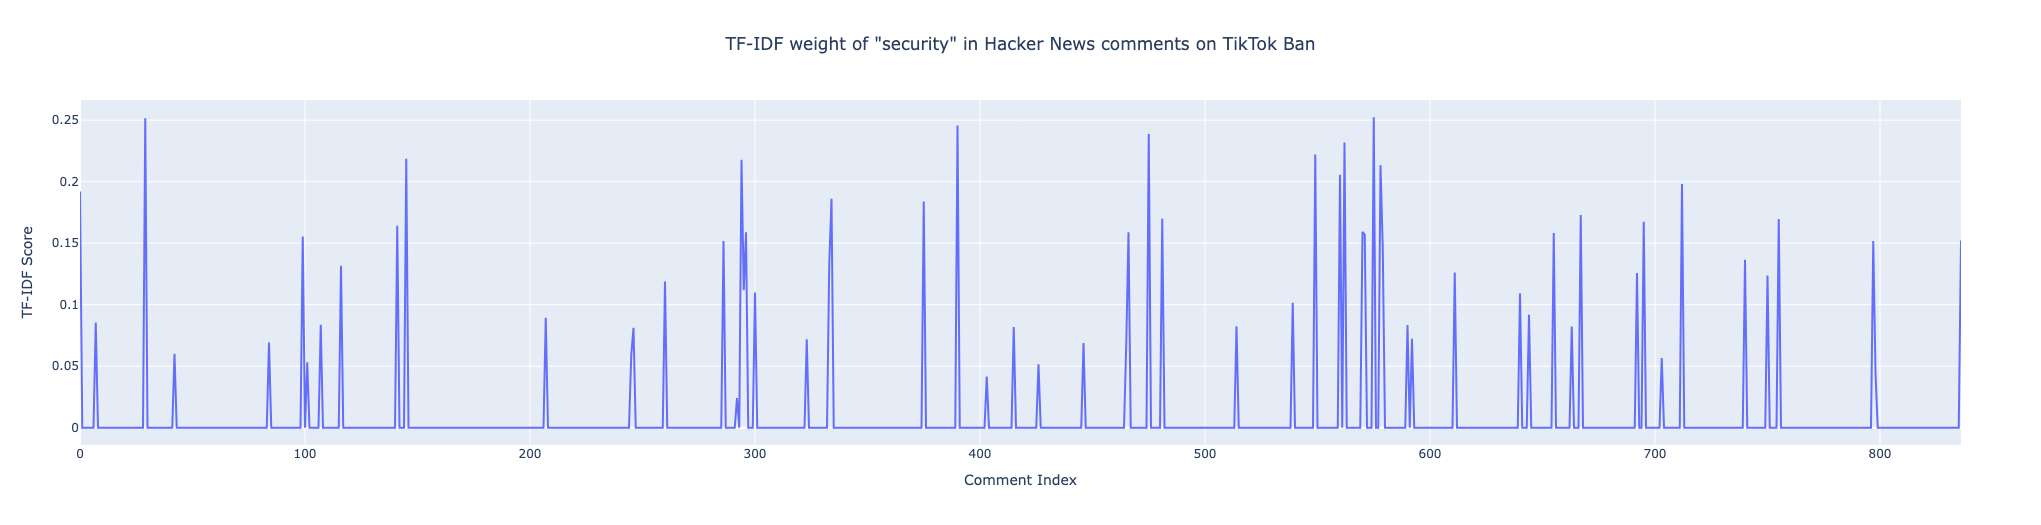

Given the quantity and amplitude of spikes in the plot, we can conclude that "security" was one of the major themes across the comments on each of the 20 stories analyzed.

# **Limitations**

The findings of this analysis should be interpreted with several limitations in mind. First, Hacker News users are not representative of the general population. The platform skews toward highly educated and predominantly male technology professionals located largely in the United States and Western Europe. Their views reflect a technically informed and economically advantaged subset of digital platform users. Second, automated sentiment analysis tools such as VADER may misclassify sarcasm, skepticism, or nuanced debate (all common communication styles on Hacker News) as neutral, underestimating the complexity of opinion. Third, the use of top-ranked comment threads introduces potential selection bias: the most visible posts may reflect early-comment dynamics or moderation norms rather than organic public interest. Finally, engagement metrics such as reply counts may be influenced by controversy, timing, or humor rather than sentiment alone. These constraints mean the results show how a tech-expert community interprets TikTok bans, not how the broader public would respond.

# **Policy Implications**

The findings from this analysis suggest several policy-relevant takeaways. First, the close-to-neutral average sentiment indicates that Hacker News users are not decisively supportive or opposed to TikTok bans, implying that regulatory proposals should clearly communicate their purpose and expected consequences to earn confidence from informed publics.

Second, the positive relationship between sentiment and engagement suggests that constructive or solution-focused messaging may encourage more productive participation in policy discussions than negative or alarm-driven framing.

Third, the difference in sentiment between U.S. and India-focused discussions shows that the context and implementing institutions matter. Users responded more favorably when they appeared to trust the underlying reasoning, indicating that transparency and clarity about motivations may influence perceptions of legitimacy.

Finally, the prominence of “security” in TF-IDF results shows that discussions are grounded primarily in risk assessment rather than ideology. Policymakers advancing platform restrictions may therefore find stronger resonance when focusing on specific, demonstrable security concerns rather than broader political narratives.

# **Conclusion**

This project examined sentiment toward TikTok bans among Hacker News users, a community deeply embedded in the technology ecosystem and attentive to cybersecurity and governance issues. The results show that although overall sentiment is close to neutral, positive comments receive greater engagement, and “security” remains the dominant framing in arguments for regulation. Slightly more positive sentiment toward U.S. policy action compared to India’s indicates that community trust in institutional motives matters as much as the technical substance of proposed bans. Taken together, the findings reveal a public that is neither reflexively anti-regulation nor uncritically accepting of intervention. Instead, users expect evidence, transparency, and proportionality when national-security concerns intersect with digital rights. As governments continue to debate platform governance, expert-adjacent online communities like Hacker News provide an important perspective on how technology policy can be both effective and democratically grounded.